# Reaction-Diffusion

## Gray-Scott model

The Gray Scott model simulates the interaction of two generic chemical species reacting and diffusing in a spatial domain. This can create an accurate behavior of the chemical species if you use the correct values. Also, creates an amazing patterns, it's awesome!

The Gray Scott model follows some simple rules. Given two sets of virtual particles $u$ and $v$:

* There's a constant feed rate of $u$ particles into the system
* If two $v$ particles meet a $u$ particle, the **convert** it into a another $v$ particle.
* There's a constant kill rate that removes $v$ particles

The Gray-Scott partial differential equations are given as:

\begin{eqnarray}
\frac{\partial u}{\partial t}=D_u\nabla^2u-uv^2+F(1-u) \\
\frac{\partial v}{\partial t}=D_v\nabla^2v+uv^2-(F+k)v
\end{eqnarray}

where

\begin{equation}
\nabla^2u=\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}
\end{equation}

Let's talk a little about the coupled system of equations. In the right hand side of each equations, the second term ($uv^2$), here you can see that this term decreases $u$ while it increases $v$ in a same amount. This because the reaction requies one unit of the species $U$ and requires two units from $V$, resulting in a reaction rate proportional to the concentration $u$ and to the square of the concentration $v$. You can explain better this behavior if you use the law of mass action, but I prefer to leave it to another time.

The terms at the end of both equations are the **feed** and **kill** rates. In this case $F(1-u)$ replenishes the species $U$ and $-(F+k)v$ is disminishing the species $V$. 

And the first term it's like the heat diffusion in the heat equation! You can see both equations and notice that this model it's similar to the heat equation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from numba import njit

I'm going to discretize the reaction-diffusion equations using forward-time central-space and assume that $\Delta x=\Delta y=\delta$.

I'm going to use a timestep using the following equation:

\begin{equation}
\Delta t=\frac{9}{40}\frac{\delta^2}{\text{max}\left(D_u,D_v\right)}
\end{equation}

Also, i'm going to use Neumann boundary conditions on all sides of the domain doing that their derivatives are equal to 0.

I'm going to use the same grid points for $x$ and $y$, both equal to 192. The domain is 5m$\times$5m for a timestep of 8000 seconds.

In [2]:
#-----------------------------------#
# Grid points and spatial variables #
#-----------------------------------#

Nx=192
Ny=192
xf=5    #5 meters
yf=5    #5 meters

dx=xf/(Nx-1)
dy=yf/(Ny-1)

x=np.linspace(0,xf,Nx)
y=np.linspace(0,yf,Ny)

#-----------------------------------#
# Another variables                 #
#-----------------------------------#

Du=0.00016
Dv=0.00008
F=0.035
K=0.065

#-----------------------------------#
# Time variables                    #
#-----------------------------------#
tf=8000 #8000 seconds
dt=(9/40)*(dx**2)/(max(Du,Dv))
Nt=int(tf/dt)
t=np.linspace(0,tf,Nt)

The system had an initial values of the concentrations $u$ and $v$. This concentrations can be random inside our spatial domain, but the conditions says that we need to had $u=1$ and $v=0$ in all the space at $t=0$s. 

Also I add a little noise in the system to help the reactions of $u$ and $v$.

In [3]:
def IC(N,Nt):
    #-------------------------------#
    # Assign the initial conditions #
    # to the system.                #
    #-------------------------------#

    #Create the arrays
    u=np.zeros((N,N,Nt))
    v=np.zeros((N,N,Nt))

    blocks=30 #This is the total of random numbers to create,

    #Create the arrays of random numbers for x and y.
    r_x=np.random.randint(1,N-1,blocks)
    r_y=np.random.randint(1,N-1,blocks)

    #Choose a parameter to add noise in the system.
    r=10
    u[:,:,0]=1

    #Add some values to create noise in the system
    for i, j in zip(r_x,r_y):
        u[i-r:i+r,j-r:j+r,0]=0.5
        v[i-r:i+r,j-r:j+r,0]=0.25

    #Finishe the noise to help the reactions
    u[:,:,0]+=0.05*np.random.random((N,N))
    v[:,:,0]+=0.05*np.random.random((N,N))

    return u,v

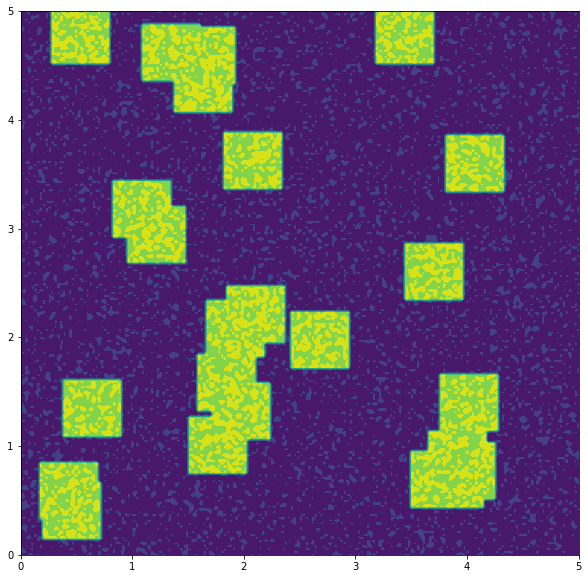

In [4]:
u,v=IC(Nx,Nt)

fig=plt.figure(figsize=(10,10))
plt.contourf(x,y,u[:,:,0])
plt.contourf(x,y,v[:,:,0])

Now, to discretize the equations i'm going to use the following equations:

\begin{eqnarray}
\frac{\partial f}{\partial t}=\frac{f_{i,j}^{k+1}-f_{i,j}^{k}}{\Delta t} \\ \\
\frac{\partial f}{\partial x}=\frac{f_{i+1,j}^{k}-2f_{i,j}^k+f_{i-1,j}^k}{\Delta x^2} \\ \\
\frac{\partial f}{\partial x}=\frac{f_{i,j+1}^{k}-2f_{i,j}^k+f_{i,j-1}^k}{\Delta y^2} \\
\end{eqnarray}

With that, my PDE are

\begin{eqnarray}
\frac{u_{i,j}^{k+1}-u_{i,j}^{k}}{\Delta t}=D_u\left(\frac{u_{i+1,j}^{k}-2u_{i,j}^k+u_{i-1,j}^k}{\Delta x^2}+\frac{u_{i,j+1}^{k}-2u_{i,j}^k+u_{i,j-1}^k}{\Delta y^2}\right)-u_{i,j}^k(v_{i,j}^k)^2+F(1-u_{i,j}^k) \\ \\

\frac{v_{i,j}^{k+1}-v_{i,j}^{k}}{\Delta t}=D_v\left(\frac{v_{i+1,j}^{k}-2v_{i,j}^k+v_{i-1,j}^k}{\Delta x^2}+\frac{v_{i,j+1}^{k}-2v_{i,j}^k+v_{i,j-1}^k}{\Delta y^2}\right)+u_{i,j}^k(v_{i,j}^k)^2-(F+k)v_{i,j}^k

\end{eqnarray}

Using algebra, I left my equations as:

\begin{eqnarray}
u_{i,j}^{k+1}=u_{i,j}^k+ D_u\frac{\Delta t}{\delta^2}\left(u_{i+1,j}^{k}+u_{i-1,j}^k+u_{i,j+1}^{k}+u_{i,j-1}^k-4u_{i,j}^k\right)-\Delta tu_{i,j}^k(v_{i,j}^k)^2+\Delta tF(1-u_{i,j}^k) \\ \\

v_{i,j}^{k+1}=v_{i,j}^k+ D_v\frac{\Delta t}{\delta^2}\left(v_{i+1,j}^{k}+v_{i-1,j}^k+v_{i,j+1}^{k}+v_{i,j-1}^k-4v_{i,j}^k\right)+\Delta tu_{i,j}^k(v_{i,j}^k)^2-\Delta t(F+k)v_{i,j}^k

\end{eqnarray}

In [36]:
def solution(Nx,Ny,Nt,dx,dy,dt,F,K,Du,Dv):
    u,v=IC(Nx,Nt)
    for k in range(Nt-1):
        #For u
        dudx=u[2:,1:-1,k]-2*u[1:-1,1:-1,k]+u[:-2,1:-1,k]
        dudy=u[1:-1,2:,k]-2*u[1:-1,1:-1,k]+u[1:-1,:-2,k]
        u_ts=u[1:-1,1:-1,k]

        #For v
        dvdx=v[2:,1:-1,k]-2*v[1:-1,1:-1,k]+v[:-2,1:-1,k]
        dvdy=v[1:-1,2:,k]-2*v[1:-1,1:-1,k]+v[1:-1,:-2,k]
        v_ts=v[1:-1,1:-1,k]

        #Calculate the next timestep
        u[1:-1,1:-1,k+1]=u_ts+(dt*Du/dx**2)*(dudx+dudy)-dt*u_ts*(v_ts**2)+dt*F*(1-u_ts)
        v[1:-1,1:-1,k+1]=v_ts+(dt*Dv/dx**2)*(dvdx+dvdy)+dt*u_ts*(v_ts**2)-dt*v_ts*(F+K)

        #Apply the boundary conditions
        u=BC(u,k+1)
        v=BC(v,k+1)

        print(k)
    
    return u,v

And for the Boundary conditions, I had:

\begin{eqnarray}
\frac{\partial u}{\partial x}=q_x \\
\frac{\partial u}{\partial y}=q_y
\end{eqnarray}

Being equal for all the ends of the system for $u$ and $v$. So, i can discretize the equations and get:

\begin{eqnarray}
\frac{u_{0,j}^k-u_{0,j}^k}{\Delta x}=q_x \\
\frac{u_{i,1}^k-u_{i,0}^k}{\Delta y}=q_y
\end{eqnarray}

Consider that $q_x=q_y=0$, i have:

\begin{eqnarray}
u_{1,j}^k=u_{0,j}^k \\
u_{i,1}^k=u_{i,0}^k
\end{eqnarray}

And that's all! I can do the same for the end $x_f$ and $y_f$, but I think that it's easy to understand. You can do it yourself!

In [22]:
def BC(f,j):
    #For x
    f[0,:,j]=f[1,:,j]
    f[-1,:,j]=f[-2,:,j]

    #For y
    f[:,0,j]=f[:,1,j]
    f[:,-1,j]=f[:,-2,j]
    return f

In [37]:
%time u,v=solution(Nx,Ny,Nt,dx,dy,dt,F,K,Du,Dv)